# Costweet : CNN + Fasttext

Ce notebook classe des phrases en 3 catégories "cher", "moyen","éco".

Il fait partie d'une série de notebook permettant de comparer différentes approches de classification en faisant varier les architectures de réseaux de neurones et les méthodes d'encodification des textes.

Il s'appuie sur un ensemble de données de petite taille.

Cet ensemble est vectorisé en utilisant la librairie fasttext de facebook (camdial.org).

Le réseau de neurones est architecturé de trois couches 2 de type convolution. Ce réseau est identique à celui utilisé par le notebook intitulé "Costweet : CNN + manuel encoding"

L'accuracy obtenu le 7 février 2018  est de 92,7% à comparer aux 85% obtenus avec avec un réseau sans convolution.

Keras uses tensorflow uses sklearn uses numpy and pandas

Ce notebook s'inspire fortement du code de François Chollet https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, Input, GlobalMaxPooling1D, MaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
#for fasttext
from __future__ import print_function
from gensim.models import KeyedVectors






Using TensorFlow backend.
d:\code\ml\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


 DATA PROCESS
 les données ont été saisies sous excel et sauvegardées en csv utf-8 bizarement avec l'option séparateur virgules de microsoft
 


In [2]:
def getDataset():
	dataset = pd.read_csv("RuleCout2.csv", delimiter=";", encoding='utf-8')
	#print ( 'dataset loaded with shape',dataset.shape)
	X = dataset['text']
	Y = dataset['class']
	dataset.set_index('text') #pour avoir les classes dans un ordre quelconque
	return dataset, X, Y

# utile pour les colonnes sur une ligne et afficher toutes les lignes
pd.set_option('display.width', 200)
pd.set_option('display.max_rows', 1000)

# on ajoutera peu à peu de nouvelles colonnes au dataset 
dataset, X, Y = getDataset()
print(dataset)

                         text  class
0             à prix modique     éco
1     aucun problème d'argent   cher
2                 avantageux     éco
3               bas de gamme     éco
4           bistrot pas cher     éco
5                         bon   cher
6                 bon marché     éco
7   bon rapport qualité prix   moyen
8                       cher    cher
9                         éco    éco
10                économique     éco
11             entre 10 et 20    éco
12             gastronomique    cher
13             haut de gamme    cher
14           j’ai les moyens    cher
15             je m’en fiche    cher
16              je m’en fous    cher
17             je suis riche    cher
18          jusqu'à cinquante   cher
19  le meilleur des meilleurs   cher
20                      luxe    cher
21                   luxueux    cher
22      ma bourse est pleine    cher
23     menu pas cher le midi     éco
24                   modique     éco
25       moins de cent euros    cher
2

# Chargement de fasttext
Fasttext needs 10 minutes to be loaded
C'est le temps de chargement du dataset fasttextwiki.fr.vec donne un vocabulaire de 1 115 449 mots et donc autant de vecteurs.

Il vaudrait mieux charger avecle .bin ce serait plus rapide. Le .bin pèse 5 gigas-octets !

Ces vecteurs ont été valorisé en utilisant l'approche skip-gram décrite dans Bojanowski et al. (2016) en utilisant les paramètres par défaut.

La dimension de ces vesteurs est de 300.

We are publishing pre-trained word vectors for 294 languages, trained on Wikipedia using fastText.
These vectors in dimension 300 were obtained using the skip-gram model described in Bojanowski et al. (2016) with default parameters. 

origine #https://blog.manash.me/how-to-use-pre-trained-word-vectors-from-facebooks-fasttext-a71e6d55f27





In [3]:
# Creating the model
fr_model = KeyedVectors.load_word2vec_format('../data/fasttextwiki.fr.vec')

# Getting the tokens 
words = []
for word in fr_model.vocab:
    words.append(word)

# Printing out number of tokens available
print("Number of Tokens: {}".format(len(words)))





Number of Tokens: 1152449


In [4]:
# encode retourne un vecteur en fonction d'un mot
def score(word):
    return  fr_model[word]

vector_troquet = score('troquet')

print ( 'score troquet', vector_troquet, len(vector_troquet))


score troquet [-0.28589    -0.26518     0.076356   -0.017638    0.20075    -0.037748
 -0.20504     0.22178    -0.16894     0.4035     -0.34198     0.037411
 -0.081518   -0.1229     -0.51538     0.0088103   0.084543   -0.082374
 -0.38133    -0.07603     0.10483    -0.019706   -0.04029     0.37365
 -0.37959    -0.54548    -0.31914    -0.31262    -0.060444   -0.053712
  0.43251    -0.1079      0.23003    -0.066676   -0.29099    -0.081674
 -0.20116    -0.32752     0.091499    0.081911    0.051361    0.076685
 -0.071495   -0.070764    0.28938    -0.12803     0.066035    0.097801
 -0.016806    0.015525    0.084922   -0.23528    -0.017823    0.4899
 -0.15586    -0.14952    -0.30836     0.12642     0.10689     0.10892
 -0.17307     0.36345     0.10455     0.60661    -0.33281    -0.18994
  0.20595     0.074113    0.1325     -0.30423     0.076651    0.18055
 -0.29682    -0.17862    -0.43857    -0.002312    0.47742     0.096643
 -0.32785    -0.067572    0.013655   -0.20559     0.49405    -0.18791

In [5]:
#ai préféré utiliser le tokenizer de keras plutôt que celui de nltk car les valeurs filtrées par défaut comprennent l'apostrophe
#def tokenize(sentence):
#	tokens = text_to_word_sequence(sentence)
#	return tokens
	
#dataset['tokens']= dataset['text'].map(tokenize)
#dataset['tokens']

MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 5
texts = dataset['text']
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

#labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
#print('Shape of label tensor:', labels.shape)
dataset['tokens']= list(data)
dataset

Found 89 unique tokens.
Shape of data tensor: (73, 5)


,text,class,tokens
0,à prix modique,éco,"[0, 0, 20, 13, 21]"
1,aucun problème d'argent,cher,"[0, 0, 35, 36, 37]"
2,avantageux,éco,"[0, 0, 0, 0, 38]"
3,bas de gamme,éco,"[0, 0, 22, 1, 8]"
4,bistrot pas cher,éco,"[0, 0, 39, 3, 2]"
5,bon,cher,"[0, 0, 0, 0, 5]"
6,bon marché,éco,"[0, 0, 0, 5, 14]"
7,bon rapport qualité prix,moyen,"[0, 5, 40, 15, 13]"
8,cher,cher,"[0, 0, 0, 0, 2]"
9,éco,éco,"[0, 0, 0, 0, 23]"


# Préparer la couche d'intégration ( the Embedding layer)

Il s'agit de construire une matrice (nombre de mots x vecteur de 300) qui permette de retrouver le vecteur de chacun des mots du vocabulaire et dinitialiser la couche d'intégration.

Un des problèmes rencontré est que faire lorsque le token ne fait pas parti des mots pré-vectorisés.

PLusieurs solutions étainet possibles on est parti pour attrapper l'erreur en cas de mot ou-of-the-vocabulary en le remplacant par le mot inconnu.

Il restera à tester d'autres familles de wrapper de textfast qui malgré que le mot soit ou-of-vacubalary arrive à lui générer un vecteur, il faudra comprendre lequel et pourquoi !!.



In [6]:
# prepare embedding matrix
EMBEDDING_DIM = 300
num_words = min(MAX_NUM_WORDS, len(word_index))
print(num_words)
embedding_matrix = np.zeros((num_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    # words not found in embedding index will be all-zeros.
    print (word,i)
    try:
        embedding_vector = fr_model[word]
    except KeyError:
        # word not found 
        embedding_vector = embedding_vector
    embedding_matrix[i]=embedding_vector
      


print(embedding_matrix.shape)
embedding_matrix



89
de 1
cher 2
pas 3
un 4
bon 5
moins 6
très 7
gamme 8
plutôt 9
le 10
euros 11
vingt 12
prix 13
marché 14
qualité 15
haut 16
je 17
peu 18
vraiment 19
à 20
modique 21
bas 22
éco 23
économique 24
m’en 25
luxueux 26
menu 27
quinze 28
ni 29
bien 30
troquet 31
standing 32
super 33
petit 34
aucun 35
problème 36
d'argent 37
avantageux 38
bistrot 39
rapport 40
entre 41
10 42
et 43
20 44
gastronomique 45
j’ai 46
les 47
moyens 48
fiche 49
fous 50
suis 51
riche 52
jusqu'à 53
cinquante 54
meilleur 55
des 56
meilleurs 57
luxe 58
ma 59
bourse 60
est 61
pleine 62
midi 63
cent 64
dix 65
trente 66
moyen 67
du 68
tout 69
trop 70
trois 71
étoiles 72
importe 73
onéreux 74
plus 75
mal 76
repas 77
plat 78
restau 79
resto 80
pour 81
gratin 82
self 83
truc 84
chicos 85
rapide 86
bistro 87
petite 88
brasserie 89
(90, 300)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.074464  , -0.018784  , -0.11756   , ...,  0.15008999,
        -0.083511  , -0.091129  ],
       [-0.31733   ,  0.13531999, -0.18532   , ..., -0.15069   ,
        -0.01545   , -0.021979  ],
       ...,
       [-0.30513999, -0.24224   , -0.14283   , ...,  0.40426001,
         0.13484   ,  0.28505   ],
       [-0.21593   , -0.24507999, -0.34255999, ..., -0.032169  ,
        -0.1661    ,  0.095957  ],
       [ 0.1567    , -0.061947  , -0.016836  , ...,  0.062614  ,
         0.44345   , -0.72491002]])

In [7]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Le prochain pavé permet de transformer les catégories "éco","moyen" et cher en vecteur.
Ces vecteurs sont rangés dans la colonne 'Ycodes' du dataset

In [8]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
dataset['Ycodes'] = pd.Series(list(dummy_y))
dataset


,text,class,tokens,Ycodes
0,à prix modique,éco,"[0, 0, 20, 13, 21]","[0.0, 0.0, 1.0]"
1,aucun problème d'argent,cher,"[0, 0, 35, 36, 37]","[1.0, 0.0, 0.0]"
2,avantageux,éco,"[0, 0, 0, 0, 38]","[0.0, 0.0, 1.0]"
3,bas de gamme,éco,"[0, 0, 22, 1, 8]","[0.0, 0.0, 1.0]"
4,bistrot pas cher,éco,"[0, 0, 39, 3, 2]","[0.0, 0.0, 1.0]"
5,bon,cher,"[0, 0, 0, 0, 5]","[1.0, 0.0, 0.0]"
6,bon marché,éco,"[0, 0, 0, 5, 14]","[0.0, 0.0, 1.0]"
7,bon rapport qualité prix,moyen,"[0, 5, 40, 15, 13]","[0.0, 1.0, 0.0]"
8,cher,cher,"[0, 0, 0, 0, 2]","[1.0, 0.0, 0.0]"
9,éco,éco,"[0, 0, 0, 0, 23]","[0.0, 0.0, 1.0]"


###MODEL DEFINITION
Le réseau comprend trois couches.

Chaque phrase est représentée à l'aide d'un vecteur de longueur cinq à l'aide d'un vocabulaire à neuf mots.

In [9]:
########################### MODEL DEFINITION
# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(1)(x)
x = Conv1D(128, 1, activation='relu')(x)
x = MaxPooling1D(1)(x)
x = Conv1D(128, 1, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)



In [10]:
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])



In [11]:
x_train = data
y_train = dummy_y

model.fit(x_train, y_train,
          batch_size=128,
          epochs=20)
#          validation_data=(x_val, y_val))
    


Epoch 1/20
73/73 [==============================] - 0s 6ms/step - loss: 1.1119 - acc: 0.2055
Epoch 2/20
73/73 [==============================] - 0s 164us/step - loss: 0.9695 - acc: 0.8493
Epoch 3/20
73/73 [==============================] - 0s 206us/step - loss: 0.7750 - acc: 0.8082
Epoch 4/20
73/73 [==============================] - 0s 233us/step - loss: 0.6286 - acc: 0.7397
Epoch 5/20
73/73 [==============================] - 0s 137us/step - loss: 0.9502 - acc: 0.4795
Epoch 6/20
73/73 [==============================] - 0s 178us/step - loss: 0.5709 - acc: 0.8219
Epoch 7/20
73/73 [==============================] - 0s 233us/step - loss: 0.4316 - acc: 0.8904
Epoch 8/20
73/73 [==============================] - 0s 137us/step - loss: 0.3482 - acc: 0.8904
Epoch 9/20
73/73 [==============================] - 0s 164us/step - loss: 0.2824 - acc: 0.9041
Epoch 10/20
73/73 [==============================] - 0s 164us/step - loss: 0.2254 - acc: 0.9178
Epoch 11/20
73/73 [==============================] 

In [12]:
###### TRAINING + EVALUATION
x_test = x_train
y_test = y_train
loss,metric = model.evaluate(x_test, y_test)
print ("Loss = ", loss," Accuracy = ",metric)

73/73 [==============================] - 0s 575us/step
Loss =  0.061138509862022856  Accuracy =  0.9726027397260274


In [13]:
dataset['predicted'] = list(model.predict(x_train)) 

def decodeY(L):
	if L[0]>L[1] and L[0]>L[2]: 
		return "cher"
	elif L[2]>L[1] and L[2]>L[0]:
		return "éco"
	else:
		return "moyen"
	
dataset['resultat']=list(map(decodeY,dataset['predicted']))
dataset


,text,class,tokens,Ycodes,predicted,resultat
0,à prix modique,éco,"[0, 0, 20, 13, 21]","[0.0, 0.0, 1.0]","[0.0028869915, 0.0008229954, 0.99628997]",éco
1,aucun problème d'argent,cher,"[0, 0, 35, 36, 37]","[1.0, 0.0, 0.0]","[0.9961815, 0.0032458212, 0.0005727005]",cher
2,avantageux,éco,"[0, 0, 0, 0, 38]","[0.0, 0.0, 1.0]","[0.029951638, 0.011383846, 0.95866454]",éco
3,bas de gamme,éco,"[0, 0, 22, 1, 8]","[0.0, 0.0, 1.0]","[0.014156244, 0.0040941495, 0.98174965]",éco
4,bistrot pas cher,éco,"[0, 0, 39, 3, 2]","[0.0, 0.0, 1.0]","[0.0046123774, 0.0004366996, 0.9949509]",éco
5,bon,cher,"[0, 0, 0, 0, 5]","[1.0, 0.0, 0.0]","[0.9829228, 0.011279484, 0.0057977736]",cher
6,bon marché,éco,"[0, 0, 0, 5, 14]","[0.0, 0.0, 1.0]","[0.07977289, 0.005762474, 0.9144646]",éco
7,bon rapport qualité prix,moyen,"[0, 5, 40, 15, 13]","[0.0, 1.0, 0.0]","[0.0056694457, 0.99392056, 0.00040998927]",moyen
8,cher,cher,"[0, 0, 0, 0, 2]","[1.0, 0.0, 0.0]","[0.84857684, 0.05515842, 0.09626466]",cher
9,éco,éco,"[0, 0, 0, 0, 23]","[0.0, 0.0, 1.0]","[0.010908019, 0.0031165478, 0.98597544]",éco


In [14]:
# split the data into a training set and a validation set
VALIDATION_SPLIT = 0.2
labels = dummy_y
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]



In [15]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=50,
          validation_data=(x_val, y_val))


Train on 59 samples, validate on 14 samples
Epoch 1/50
59/59 [==============================] - 0s 203us/step - loss: 0.0712 - acc: 0.9661 - val_loss: 0.0112 - val_acc: 1.0000
Epoch 2/50
59/59 [==============================] - 0s 186us/step - loss: 0.0585 - acc: 0.9831 - val_loss: 0.0153 - val_acc: 1.0000
Epoch 3/50
59/59 [==============================] - 0s 220us/step - loss: 0.0477 - acc: 1.0000 - val_loss: 0.0092 - val_acc: 1.0000
Epoch 4/50
59/59 [==============================] - 0s 169us/step - loss: 0.0370 - acc: 0.9831 - val_loss: 0.0110 - val_acc: 1.0000
Epoch 5/50
59/59 [==============================] - 0s 254us/step - loss: 0.0309 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 1.0000
Epoch 6/50
59/59 [==============================] - 0s 237us/step - loss: 0.0280 - acc: 0.9831 - val_loss: 0.0091 - val_acc: 1.0000
Epoch 7/50
59/59 [==============================] - 0s 237us/step - loss: 0.0347 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 8/50
59/59 [==============

In [20]:
labels


array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

In [21]:
dataset['predicted'] = list(model.predict(data)) 

def decodeY(L):
	if L[0]>L[1] and L[0]>L[2]: 
		return "cher"
	elif L[2]>L[1] and L[2]>L[0]:
		return "éco"
	else:
		return "moyen"
	
    
def color_negative_red(val1,val2):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val1 <> val2 
    return 'color: %s' % color


dataset['resultat']=list(map(decodeY,dataset['predicted']))
dataset


,text,class,tokens,Ycodes,predicted,resultat
0,à prix modique,éco,"[0, 0, 20, 13, 21]","[0.0, 0.0, 1.0]","[0.9999994, 1.3785315e-07, 4.5189665e-07]",cher
1,aucun problème d'argent,cher,"[0, 0, 35, 36, 37]","[1.0, 0.0, 0.0]","[3.756525e-05, 3.0145458e-05, 0.9999323]",éco
2,avantageux,éco,"[0, 0, 0, 0, 38]","[0.0, 0.0, 1.0]","[0.9998739, 9.879082e-05, 2.7242355e-05]",cher
3,bas de gamme,éco,"[0, 0, 22, 1, 8]","[0.0, 0.0, 1.0]","[2.9434625e-05, 3.69972e-06, 0.99996686]",éco
4,bistrot pas cher,éco,"[0, 0, 39, 3, 2]","[0.0, 0.0, 1.0]","[0.9999372, 5.631876e-05, 6.5845024e-06]",cher
5,bon,cher,"[0, 0, 0, 0, 5]","[1.0, 0.0, 0.0]","[0.99999535, 1.7090036e-06, 2.98879e-06]",cher
6,bon marché,éco,"[0, 0, 0, 5, 14]","[0.0, 0.0, 1.0]","[0.99999964, 3.591031e-07, 1.4333833e-09]",cher
7,bon rapport qualité prix,moyen,"[0, 5, 40, 15, 13]","[0.0, 1.0, 0.0]","[2.5288664e-05, 1.1820878e-06, 0.99997354]",éco
8,cher,cher,"[0, 0, 0, 0, 2]","[1.0, 0.0, 0.0]","[0.9999994, 5.090719e-07, 1.5610726e-07]",cher
9,éco,éco,"[0, 0, 0, 0, 23]","[0.0, 0.0, 1.0]","[0.99992466, 6.693486e-05, 8.38465e-06]",cher


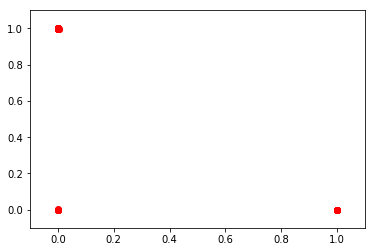

In [29]:
import matplotlib
import matplotlib.pyplot as plt


for x,y,z in dataset['predicted']:
    #print(x,z)
    plt.plot(x,z,'ro')


#plt.plot([1,2,3,4], [1,4,9,16], 'ro')
plt.axis([-0.1, 1.1, -0.1, 1.1])
plt.show()